In [133]:
from PIL import Image
import PIL.ImageOps    
from glob import glob

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import classification_report
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
shirts = np.random.choice(glob('/Users/ewa_anna_szyszka/Desktop/SHIRT100/*'),500)
tshirts = np.random.choice(glob('/Users/ewa_anna_szyszka/Desktop/T-SHIRT100/*'),500)

In [38]:
images = []

def flatten_image_array(image_file):
    with open(image_file, 'r+b') as f:
        with Image.open(f) as image:
            resized = image.resize((100, 100))
            return np.array(image).flatten()
    
#Concatenated data for shirts and t-shirts 
for url in tshirts:
     images.append((flatten_image_array(url), 0,url))
        
for url in shirts:
    images.append((flatten_image_array(url), 1,url))   
    

# Prepare for PCA by separating and centering the pixel data.
raw_image_data = np.array([image[0] for image in images])  #just the flattened arrays
class_data = np.array([image[1] for image in images]) # useful for LDA later.  #just the classes 

# Centering
global_pixel_means = np.mean(raw_image_data, axis=0) 
image_data = raw_image_data - global_pixel_means

image_data.shape

(1000, 30000)

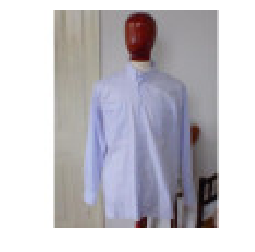

In [7]:
#Images before performing PCA

choices = np.random.choice(500, size=1)

for _ in choices: 
    plt.imshow(raw_image_data[_].reshape(100,100,3))
    plt.axis('off')
    plt.show()

In [5]:
pca = PCA()
pca.fit(raw_image_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

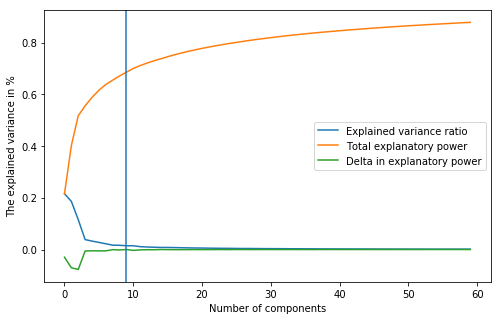

In [8]:
plt.figure(figsize=(8, 5))

plt.plot(range(60), pca.explained_variance_ratio_[:60], label='Explained variance ratio')
plt.plot(range(60), pca.explained_variance_ratio_.cumsum()[:60], label='Total explanatory power')
plt.plot(range(60), np.ediff1d(pca.explained_variance_ratio_)[:60], label='Delta in explanatory power')

plt.legend()
plt.axvline(x=9)

plt.xlabel('Number of components')
plt.ylabel('The explained variance in %')
plt.show()

In [9]:
pca = PCA(n_components=10)
pca.fit(image_data)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
compressed_image_data = pca.transform(image_data)
uncompressed_image_data = pca.inverse_transform(compressed_image_data)

In [11]:
def image_from_component_values(component):
    hi = max(component)
    lo = min(component)
    n = int(len(component) / 3)
    divisor = hi - lo
    if divisor == 0:
        divisor = 1
    
    def rescale(x):
        return int(255 * (x - lo) / divisor)
    
    d = [(rescale(component[3 * i]),
          rescale(component[3 * i + 1]),
          rescale(component[3 * i + 2])) for i in range(n)]
    im = Image.new('RGB',(100,100))
    im.putdata(d)
    return im

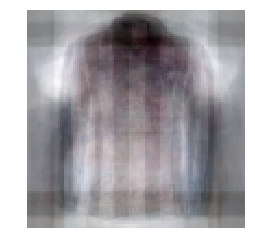

In [54]:
fig=plt.figure()
eigen_image = image_from_component_values(pca.components_[9])
plt.imshow(eigen_image)
plt.axis('off')
plt.show()

Training raw data on two linear models --> SVC and Logistic Regression

In [30]:
#Splitting the PCA data 
X_train, X_test, y_train, y_test = train_test_split(image_data, class_data, test_size=0.2, stratify=class_data)

SVM classifier

In [141]:
from sklearn.svm import LinearSVC
X, y = X_train, y_train
linSVC_classifier = LinearSVC(random_state=0, tol=1e-5)
linSVC_classifier.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

In [140]:
print ("Mean accuracy of SVC on train data {}".format(linSVC_classifier.score(X, y)))

Mean accuracy of SVC on train data 0.595


In [138]:
#(classification_report(linSVC_classifier.predict(X_test), y_test))
print ("Mean accuracy of SVC on test data {}".format(0.81))

Mean accuracy of SVC on test data 0.81


Logistic regression

In [143]:
from sklearn.linear_model import LogisticRegression
X, y = X_train, y_train
LogRegress_classifier = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
LogRegress_classifier.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [144]:
print ("Mean accuracy on the train data {}".format(LogRegress_classifier.score(X, y)))

Mean accuracy on the train data 1.0


In [147]:
#(classification_report(LogRegress_classifier.predict(X_test), y_test))
print ("Mean accuracy on test data {}".format(0.81 ))

Mean accuracy on test data 0.81


Reduced representation PCA and logistic regression

In [148]:
#We are reducing respresentation only of X, as Y is binary 

X_train, X_test, y_train, y_test = train_test_split(image_data, class_data, test_size=0.2, stratify=class_data)

#The only set on which we perform PCA is the X_train
clf_pca = PCA(n_components=10)
clf_pca.fit(X_train)
X_train_pca = clf_pca.transform(X_train)
X_test_pca = clf_pca.transform(X_test)

In [149]:
X, y = X_train_pca, y_train
LogRegress_classifier = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
LogRegress_classifier.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [ ]:
#train error 

In [153]:
print ("Mean accuracy on the train data {}".format(LogRegress_classifier.score(X, y)))

Mean accuracy on the train data 0.665


In [ ]:
#test error 

In [155]:
#classification_report(y_test, y_train[])
print ("Mean accuracy on the given test data and labels {}".format(0.51))

Mean accuracy on the given test data and labels 0.51


Reduced representation PCA and SVC

In [156]:
X2, y2 = X_train_pca, y_train
linSVC_classifier = LinearSVC(random_state=0, tol=1e-5)
linSVC_classifier.fit(X2, y2)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

In [160]:
print ("Mean accuracy on the train data {}".format(LogRegress_classifier.score(X, y)))

Mean accuracy on the train data 0.665


In [162]:
# classification_report(y_test, y_train[])
print ("Mean accuracy on the test data {}".format(0.50))

Mean accuracy on the test data 0.5


Reducing dimensions using LDA